# Point processes #

A _point process_ is a way of "randomly" choosing points in space.

In this first notebook, we will look at one dimensional processes (which we can think of as a genuine "process" evolving in time) and at a number of different models for two dimensional processes.

## Links ##

- [Wikipedia page on Point Processes](https://en.wikipedia.org/wiki/Point_process)
- [Poisson point process](https://en.wikipedia.org/wiki/Poisson_point_process)
- [Lecture notes](http://people.math.aau.dk/~jgr/teaching/punktproc11/tpp.pdf) from [Jakob G. Rasmussen ](http://people.math.aau.dk/~jgr/)
- [Hawkes processes](https://arxiv.org/abs/1507.02822) - Survey paper on the arXiv

In [148]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import utils

<module 'utils' from '/nfs/see-fs-02_users/matmdpd/notebooks/utils.py'>

The simplest point process to model is a Poisson point process on the line.  I find this easiest to think about as a genuine "process" evolving in time.
- Start from time 0
- We independently sample a "waiting time" from an [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution)
- Events occur one by one after waiting for the "waiting time"

In [140]:
def add_point(points, scale=2.0):
    wait_time = np.random.exponential(scale=2.0)
    if len(points) == 0:
        last = 0
    else:
        last = points[-1]
    points.append(last + wait_time)

def sample_poisson_process(window_size=100, scale=2.0):
    points = []
    add_point(points, scale)
    while points[-1] < window_size:
        add_point(points, scale)
    return points

points = sample_poisson_process()
points[:5]

[0.17396731887602837,
 0.18448965707296705,
 0.3516906986979521,
 19.051687252646904,
 23.089825508465985]

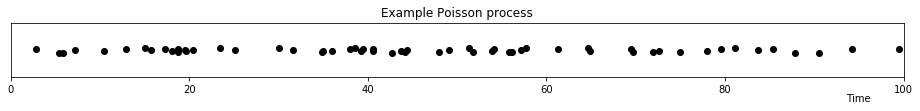

In [73]:
utils.plot_series(points, title="Example Poisson process")

To visualise a point process, where some events may very closely overlap, we follow the common trick of adding random jitter to the y axis.

Why is a "Poisson process" called so, when we used an exponential distribution?  To answer this, we need to think of point processes not as evolving in time, but as being generated all at once.

- So we "randomly choose" some points in our window, here the interval from 0 to 100
- The Poisson processes is characterised by the fact that the gaps between successive points are independently distributed as an exponential distribution

An alternative characterisation of the Poisson process is to look at a sub window, say $[a,b]$.  Then the _number_ of points should be distributed as a Poisson distribution.

- If we sampled the gaps from an exponential distribution with "rate parameter" $\lambda$ or "scale" $1/\lambda$,
- then in an interval of length $l$ ($=b-a$ here) the number of points will be distributed as a Poisson distribution with parameter $l\lambda$

Auto ranged 5 -> 27


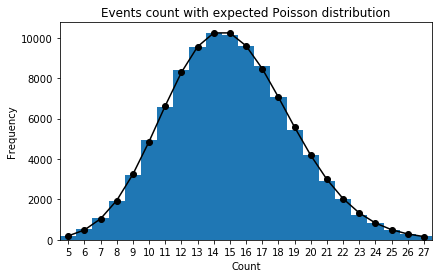

In [90]:
a, b = 20, 50
samples = 100000
scale = 2.0

counts = [
    sum( x>=a and x<=b for x in sample_poisson_process() )
    for _ in range(samples) ]

expect = { x : scipy.stats.poisson.pmf(x, (b-a)/scale) for x in range(100) }

utils.histogram_with_expected(counts, expect, title="Events count with expected Poisson distribution")

Suppose we wish to simulate a Poisson process "directly", without simulating the "gaps".

- The key mathematical fact is that in a "window", conditional on the number of points, the distribution of points is uniformly at random, and independent.
- So to simulate a Poisson process, we first draw a sample from the relevant Poisson distribution to decide on the number of points $N$,
- and then we sample $N$ points independently from a uniform distribution.

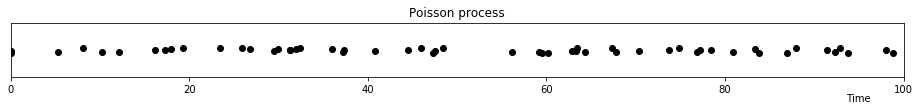

In [99]:
def sample_poisson_process_directly(window_size=100, scale=2.0):
    number_points = np.random.poisson(window_size / scale)
    points = np.random.uniform(low=0, high=window_size, size=number_points)
    points.sort()
    return points

points = sample_poisson_process_directly()
utils.plot_series(points, title="Poisson process")

If we sample repeatedly in this way, and compute the "gaps", then we should be drawing samples from an exponential distribution.

- A subtle point here is that each sample is really a "window" onto an infinite process.
- To compute the "gaps" properly, we should not ignore the "gap" between the last point of one window, and the first point of the next window.
- If this seems odd to you, then imagine what would happen if the window size were very small.  In this case, we'd expect, on average, less than one event per window, and so it would be important to consider more than one window.  As the window size gets larger, this becomes less important, but ignoring it completely still introduces a bias.

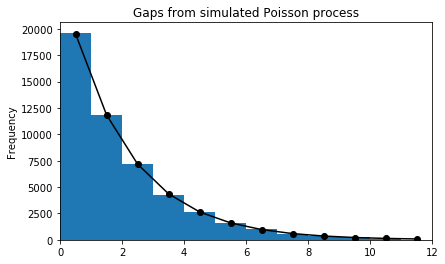

In [151]:
window_length = 100
points = sample_poisson_process_directly(window_size=window_length)
gaps = [y-x for x,y in zip(points[:-1], points[1:])]
last_point = points[-1]

for _ in range(1000):
    points = sample_poisson_process_directly()
    gaps.append(points[0] - (last_point - window_length))
    gaps.extend(y-x for x,y in zip(points[:-1], points[1:]))
    
def exponential(a, b):
    return scipy.stats.expon.cdf(b, scale=2.0) - scipy.stats.expon.cdf(a, scale=2.0)

expected = { x : exponential(x, x+1) for x in range(20) }
utils.histogram_continuous(gaps, 1, expected, "Gaps from simulated Poisson process")

# Spatial point processes #

It is very easy to generalise the "counting" approach to the Poisson point processes to two dimensions.

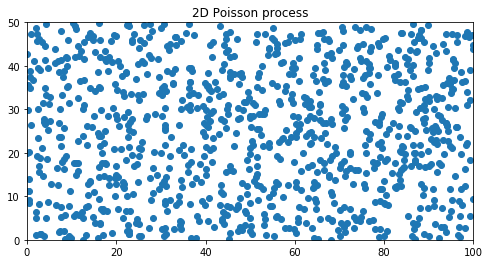

In [166]:
scale = 5.0
window_size = np.array([100,50])
number_points = np.random.poisson(window_size[0] * window_size[1] / scale)
points = np.random.rand(number_points, 2) * window_size

utils.plot_spatial(points, "2D Poisson process", [0,100], [0,50])

In this example, the "rate" or "density" or _intensity_ of the points is constant: if you took lots of samples, and compared a small window near $(0,0)$ with a small window near $(50,50)$ they should on average look the same.

Let us start to think about how to vary the intensity.  Formally, suppose we have function $f(x,y)$ which is the intensity of the process at $(x,y)$.  How do we sample from such a process?

- We shall follow a [Rejection Sampling](https://en.wikipedia.org/wiki/Rejection_sampling) approach.
- This works well for simple examples, but it suffers from the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)
- In future, we shall be interested in processes which _do_ evolve in time (as well as having a spatial component) and in these cases, other methods are available

For a simple example, we shall consider the window $[0,100] \times [0,50]$ as before, but with an intensity function
$$ f(x,y) = \exp(y/50) / 5$$
whereas before we used the constant $1/5$.

The total intensity is then
$$ \int_0^{100} \int_0^{50} \frac{\exp(y/50)}{5} \ dx \ dy = 100\times 50\times (e^1-1)/5 \approx 1718 $$

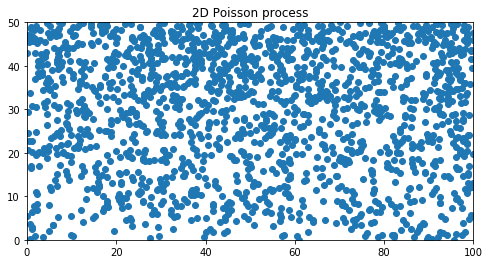

In [181]:
total_intensity = 100*50*(np.exp(1)-1) / 5
max_intensity = np.exp(1)/5

number_points = np.random.poisson(100 * 50 * max_intensity)
points = []
for _ in range(number_points):
    x = np.random.uniform(0, 100)
    y = np.random.uniform(0, 50)
    intensity = np.exp(y / 50.0) / 5
    if intensity >= np.random.uniform(0, max_intensity):
        points.append([x,y])
    
points = np.array(points)
utils.plot_spatial(points, "2D Poisson process", [0,100], [0,50])